# README

## Overall Approach

- Take the image preprocessing and the first ~~forty four~~ twelve layers (convolutions ~~plus two inception modules~~) from the InceptionV3 network --- the `base_model`.
- Apply a 3-sigma Gaussian filter to the steering angles in the training data to smooth them, because my keyboard input was quite spikey.
- Also use the udacity training dataset, which was released after I collected my own data (but do not apply smoothing to it). 
- Run the images through the base model to produce bottleneck features.
  - Also use the left and right camera images and bias the steering angle by 1.5 degrees toward the center.
  - Also reflect the images horizontally and flip the sign of the angle.
  - That givess 6 features per frame in total.
- Train a deep neural net (see architecture below) with the bottleneck features as inputs.
- Evaluate the model for roughly 100 different sets of hyperparameters (see Appendix) to produce a shortlist of about 50 that have below average Mean Absolute Error (MAE). (Networks trained on MAE were found to be better empirically.) (Repeated with about 20 sets of hyperparameters and a shortlist of 5 for resubmission.)
- Evaluate the shortlist on the simulator. The networks with the lowest MAE were not always the ones that performed the best on the track.

## Resubmission Notes

- The model failed to drive around the track on the reviewer's computer. My best guess is that it was a performance problem, because I saw similar failures when I ran the code on an older laptop. To investigate, I added added timing info into my drive.py output (this was on my faster laptop):
```
dt: 0.177s	dt_base: 0.174s	sa: 0.014	throttle=0.172	new throttle=0.315
dt: 0.174s	dt_base: 0.169s	sa: 0.014	throttle=0.179	new throttle=0.311
dt: 0.167s	dt_base: 0.165s	sa: 0.014	throttle=0.179	new throttle=0.311
dt: 0.151s	dt_base: 0.147s	sa: 0.038	throttle=0.173	new throttle=0.221
```
Here the `dt` is the total prediction time per frame and the `dt_base` is how long it takes to pass the frame through the base model. Clearly the base model dominates the total frame time. On my faster laptop, frame times were about 0.15s, which seemed to work fine, but on my slower laptop, it was around 0.5s per frame, which is quite slow.

- I was originally using the first 44 layers of the inception network, so I tried the first 28 layers instead; that reduced the times somewhat, but it was still around 0.4s per frame on my old laptop, which was still quite slow. So I decided to try cutting the network before the first inception module, after just the convolutions. That has the frame times down to about 0.25s per frame, which seems to be just fast enough. It does drive noticeably better on my faster laptop, which has frame times just below 0.1s per frame. This is all on CPU (no GPU involved).

- For good measure, since I don't have a lot of data to support my performance problem hypothesis, I decided to add in the extra training data that udacity released and to use the 'reflect horizontally' trick, which I saw mentioned on Slack. That increased the amount of training data by 60% with the udacity data, and then by a further 100% with horizontal reflections (summary is below).

- The reviewer also requested examples of images from the dataset, which I have now included. (There were some videos before, but now there are also images.)

## Request for Information if it Fails Again

If it still doesn't drive, could you please include some of the `drive.py` output showing the timings in your review, so I can assess whether it was slower or faster than in my testing.

It would also be helpful if you could confirm the settings used for the simulator: I have done all of my work on the lowest resolution (640x480) with 'Fastest' quality.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gzip
import os
import pickle
import platform

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import bottleneck_features
import preprocess
import model_io
import batch
import model

Using TensorFlow backend.


# Base Model

The full inception model is too slow for real time use on my laptop, so I am just using the first few layers. Loading the whole inception model is also very slow, so cut out only the weights we need and save them for loading later.

In [3]:
import inception
import model_io

CUT_INDEX = 12 # layer 12 is before the first inception module

if not os.path.exists(base_model_stem(CUT_INDEX) + '.json'):
    model_io.save_model(
        base_model_stem(CUT_INDEX) + '.json',
        base_model_stem(CUT_INDEX) + '.h5',
        inception.make_cut_model(CUT_INDEX))

In [4]:
model_io.load_base_model(CUT_INDEX).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 79, 159, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 79, 159, 32)   64          convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 77, 157, 32)   9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

## Preprocessing

- Correct the image file paths, since I have several driving logs in different folders.
- Smooth the control inputs. The input from me is quite spikey, because all I can do is press a button or not. This seems like it would make learning quite difficult, so apply smoothing.
- Bottleneck the features to make training reasonably fast.

### Training (and Validation) Data

I started out by driving around quite fast and cutting corners (`ccw_1` and `cw_1`) and then doing several laps with recovery, as suggested in the assignment spec. I did both clockwise and counterclockwise on the first training track.

Model performance was not very good on the fast data, so I recorded some slower (roughly 10mph) data, trying to be very careful about staying in the middle of the road. Performance was much better on the slower datasets. (I later modified `drive.py` to keep the speed at about 10mph to match the training data.)

The main place where the model had problems was with the turnout after the bridge. It would often drive into it, and I did not provide any training data in there, so it usually got lost and crashed. I recorded four more drives around that corner, and now at least some of the models turn correctly to avoid the turnout.

In [5]:
log = pd.concat([
    # preprocess.run('data/ccw_1', CUT_INDEX), # driving fairly aggressively
    # preprocess.run('data/cw_1', CUT_INDEX),
    preprocess.run('data/ccw_2', CUT_INDEX),
    preprocess.run('data/cw_2', CUT_INDEX),
    preprocess.run('data/ccw_recover_from_right_1', CUT_INDEX),
    preprocess.run('data/ccw_recover_from_left_1', CUT_INDEX),
    preprocess.run('data/cw_recover_from_right_1', CUT_INDEX),
    preprocess.run('data/cw_recover_from_left_1', CUT_INDEX),
    preprocess.run('data/ccw_turnout_1', CUT_INDEX),
    preprocess.run('data/ccw_turnout_2', CUT_INDEX),
    preprocess.run('data/udacity', CUT_INDEX, header=0, smooth=False)
])
print(log.head())

data/ccw_2/bottleneck_12 exists; just binding.
data/cw_2/bottleneck_12 exists; just binding.
data/ccw_recover_from_right_1/bottleneck_12 exists; just binding.
data/ccw_recover_from_left_1/bottleneck_12 exists; just binding.
data/cw_recover_from_right_1/bottleneck_12 exists; just binding.
data/cw_recover_from_left_1/bottleneck_12 exists; just binding.
data/ccw_turnout_1/bottleneck_12 exists; just binding.
data/ccw_turnout_2/bottleneck_12 exists; just binding.
data/udacity/bottleneck_12 exists; just binding.
                 bottleneck_features  brake  \
0  data/ccw_2/bottleneck_12/0000.npz    0.0   
1  data/ccw_2/bottleneck_12/0001.npz    0.0   
2  data/ccw_2/bottleneck_12/0002.npz    0.0   
3  data/ccw_2/bottleneck_12/0003.npz    0.0   
4  data/ccw_2/bottleneck_12/0004.npz    0.0   

                                        center_image dataset  \
0  data/ccw_2/IMG/center_2016_12_10_17_02_46_943.jpg   ccw_2   
1  data/ccw_2/IMG/center_2016_12_10_17_02_47_043.jpg   ccw_2   
2  data/ccw_2

###  Dataset Summary


In [6]:
def summarize_dataset():
    groups = log.groupby('dataset')
    totals = groups['center_image'].agg([len])
    mean_speed = groups['speed'].mean()
    mean_steering_angle = groups['steering_angle'].mean()
    return pd.concat([totals, mean_speed, mean_steering_angle], axis=1)
summarize_dataset()

,len,speed,steering_angle
dataset,,,
ccw_2,2882,8.833225,-0.041838
ccw_recover_from_left_1,1405,11.775736,0.050748
ccw_recover_from_right_1,1361,10.212416,-0.123761
ccw_turnout_1,713,9.905384,-0.085719
ccw_turnout_2,522,9.295456,-0.111309
cw_2,2391,9.972545,0.036800
cw_recover_from_left_1,1550,10.484323,0.128920
cw_recover_from_right_1,1721,8.972610,0.017962
udacity,8036,28.169839,0.004070


### Example Images with Bottleneck Features

Here are example images from a single frame. Images from each of the three cameras are included, together with their horizontal reflections. The first three feature channels in the bottleneck features for each image are also plotted.

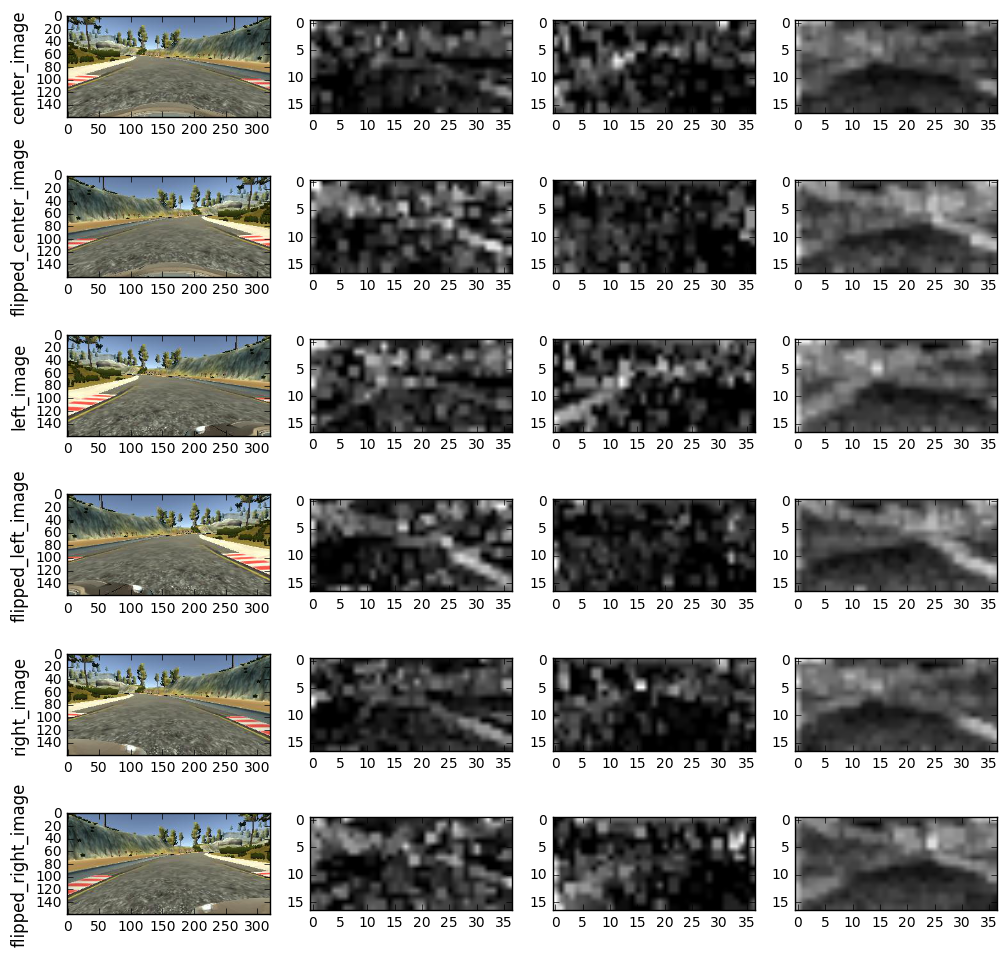

In [7]:
def show_example_images(index, num_channels):
    log_batch = log.iloc[index:index + 1] # batch of one
    bottleneck = batch.load_bottleneck_files(log_batch)[0]
    images, column_names = bottleneck_features.make_batch_images(log_batch)
    num_files = len(column_names)
    fig, axes = plt.subplots(
        num_files, num_channels + 1,
        figsize=(3*(num_channels + 1), 2*num_files))
    for i, column_name in enumerate(column_names):
        axes[i][0].set_ylabel(column_name, rotation=90, size='large')
        axes[i][0].imshow(images[i])
        for j in range(num_channels):
            axes[i][j + 1].imshow(bottleneck[column_name][:,:,j], cmap='gray')
show_example_images(100, 3)

### Steering Angle Smoothing

I tried two types of smoothing (implemented in `preprocess.py`):

- Exponential smoothing: an exponential weighted moving average (`smooth_steering_angle_1`)
- Gaussian smoothing: a 1D gaussian filter with sigma 3 (`smooth_steering_angle_gaussian_3`)

Both seem to track pretty well, but the gaussian smoothing is better at preserving the mean steering angle and gave better results overall in the model. I also tried a sigma 5 gaussian, but results were worse.

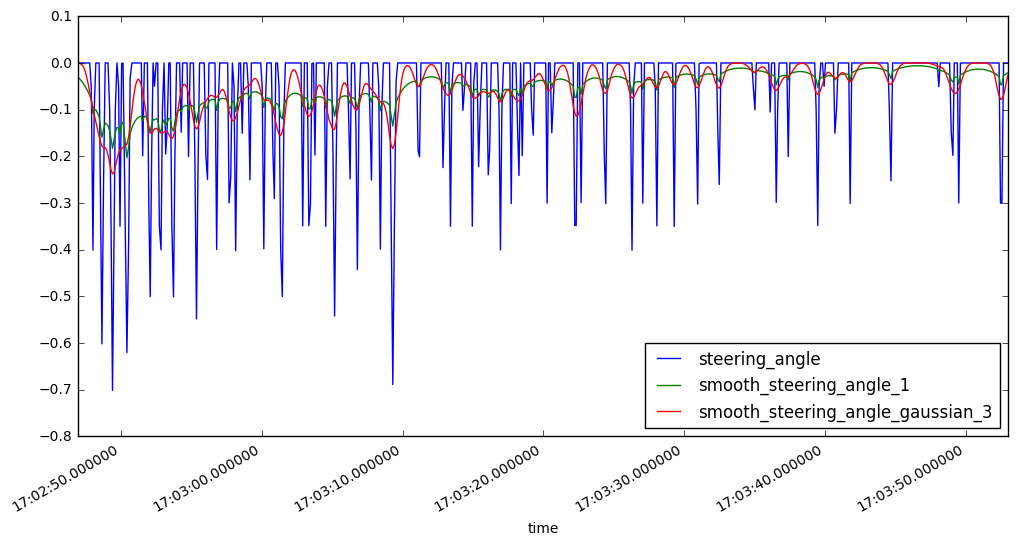

In [8]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'smooth_steering_angle_gaussian_3']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

### Smoothed Steering Video

To check that the datasets were sane, I made some videos (not included, since they are rather large --- there is a video below showing a prediction on `ccw_2`, which is included).

In [9]:
def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -25 degrees to 25 degrees.
    """
    return math.radians(steering_angle * 25.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filestem,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    if platform.system() == 'Linux':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        filename = filestem + '.avi'
    else:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')        
        filename = filestem + '.mp4'
    
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
#         if i % 50 == 0:
#             print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)

        cv2.putText(image, log['center_image'].values[i],
                    (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.1, 0)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()
    
for dataset in log['dataset'].unique():
    make_steering_movie(os.path.join('data', dataset, 'check'),
                        log[log['dataset'] == dataset][0:100],
                        'smooth_steering_angle_1')

## Model

The model is defined in `model.py`. The layers and the sizes used for the submitted model are: 

1. Inputs: 17 x 37 x 192 bottleneck features from layer 12 of the InceptionV3 network
1. 1x1 convolution with 16 filters to reduce the dimensionality of the bottleneck features, in order to make the model a more manageable size.
1. Flatten
1. Dense fully connected layer with 32 units and tanh activation (empirically better than relu; see Appendix).
1. Dense output layer with a single output, namely the steering angle.

The submitted network was one of many networks tested in the simulator (see Appendix). Using these parameters does not always produce a particularly good network; there is a fairly large amount of randomness in the training.

### Training / Validation Split and Batches

The bottleneck features (and corresponding labels) are shuffled and then split. To improve performance, we save one batch per `npz` file, so we can just load a single batch at a time.

In [25]:
batch_params = {
    'cut_index': CUT_INDEX,
    'test_size': 0.2,
    'random_state': 42,
    'batch_size': 128,
    'label_column': 'smooth_steering_angle_gaussian_3',
    'side_camera_bias': 1.5/25,
    'flip': True,
}
nb_train, batch_files_train, nb_val, batch_files_val, batch_train_indexes = \
batch.make_train_val_batches(log, batch_params)

### Check Batch Data

The label order is center cam, reflected center, left cam, reflected left, rightcam, reflected right.

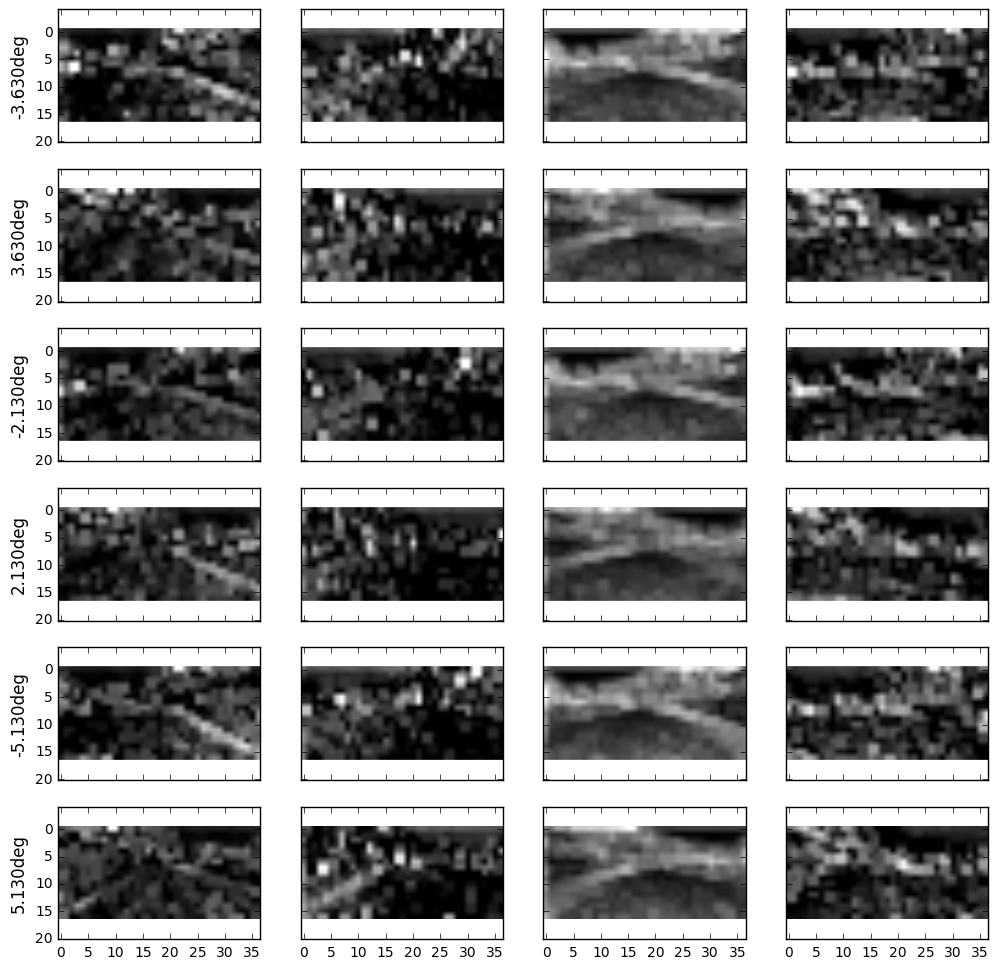

In [39]:
def show_batch_example(batch_index, batch_size, index, num_features, num_channels):
    with np.load(batch_files_train[batch_index]) as batch:
        features, labels = batch['features'], batch['labels']
    fig, axes = plt.subplots(
        num_features, num_channels,
        figsize=(3*num_channels, 2*num_features),
        sharex=True, sharey=True)
    for i in range(num_features):
        degrees = (25 * labels[index + i*batch_size])
        axes[i][0].set_ylabel('%.3fdeg' % degrees, rotation=90, size='large')
        for j in range(num_channels):
            axes[i][j].imshow(features[index + i*batch_size,:,:,j], cmap='gray')
show_batch_example(0, 128, 0, 6, 4)

### Training

Training uses the Adam optimizer with its default parameters.

The model includes L2 regularization on the weights.

The submitted model was trained as part of the parameter sweeps in the appendix, but the parameters shown here are the ones used.

In [26]:
steering_model = model.build(
    input_shape=np.load(log['bottleneck_features'].values[0])['center_image'].shape,
    nb_filter=16,
    nb_hidden=32,
    l2_weight=0.02,
    optimizer='adam'
)

history = model.train(
    steering_model,
    nb_epoch=30,
    patience=2,
    nb_train=nb_train,
    batch_files_train=batch_files_train,
    nb_val=nb_val,
    batch_files_val=batch_files_val,
    save_stem='model')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 17, 37, 16)    3088        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 10064)         0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 32)            322080      flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             33          dense_1[0][0]                    
Total params: 325201
______________________________________________________________________

In [40]:
# load model with best validation loss
steering_model = model_io.load_model('model.json', 'model.h5')

In [41]:
def make_prefix_prediction(end):
    df = log[:600].copy()
    df['predicted_steering_angle'] = steering_model.predict_on_batch(
        batch.make_batch(
            df,
            label_column=batch_params['label_column'],
            side_camera_bias=None,
            flip=False)[0])
    return df
log_prefix_with_prediction = make_prefix_prediction(600)

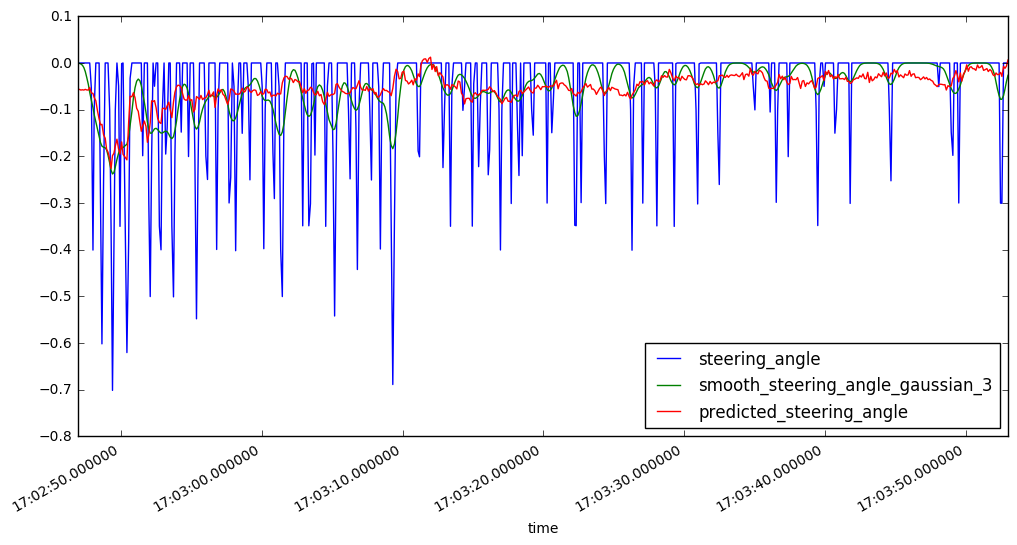

In [42]:
def plot_predicted_steering_angle():
    df = log_prefix_with_prediction[
        ['time', 'steering_angle', batch_params['label_column'], 'predicted_steering_angle']]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

Here's a video showing performance on the first part of the dataset. The colors in the video are:

- blue: actual (unsmoothed) steering input in the training data
- green: smoothed input in the training data (gaussian 3 sigma)
- red: predicted steering angle

Note: if it doesn't embed, here is a link: [test.avi](test.avi).

In [14]:
make_steering_movie('test', log_prefix_with_prediction, batch_params['label_column'], 'predicted_steering_angle')

In [15]:
from IPython.display import HTML
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format('test.avi'))

# Appendix: Experiment Notes and Parameter Sweeps


## Experiments with Unsmoothed Steering Angles

- Tried just adding a linear model (32--128 units, L2 regularization with weights 0.001--0.01) after the 1x1 convolution, but validation loss generally bottomed out at about MSE 0.04, which is too high. It also tended to diverge, at least with the Adam optimizer.
- Tried adding a hidden layer (32-128 units) with ReLU activation and dropout before the linear layer, but that seemed to just predict a small constant steering angle most of the time. Maybe a "dying relus" problem. It seems you can get an MSE around 0.05 by just predicting a constant near zero all the time.
- So I tried tanh activation instead, but that did not seem to help.
- I switched back to L2 regularization with ReLUs, which did a bit better but still understeered.
- I think the problem is that it's too easy to just ignore my occasional steering inputs (key presses).

## Experiments with Smoothed Steering Angles

- Tried the linear model again. No longer predicting constants, but it starts overfitting (increase in validation loss) after only a couple of epochs. Probably going to need something more expressive.
- Tried adding hidden layer (32 units) with ReLU activation and L2 regularization (weight 0.01). Still mostly predicting a small constant.
- Tried tanh activation on the hidden layer. Now it seems much happier: getting to the bridge and MSE 0.015 with nb_filter=64, nb_hidden=32 and l2_weight=0.01. Still understeering a bit on gentler bends.
- Tried reducing L2 weight to 0.005. That seemed to slow down training quite a lot; got to MSE 0.017 after 16 epochs. Still understeering and weaving a bit.
- Tried mean absolute error instead of mean squared error, since all of the errors are actually pretty small. New record on first run: made it to the turnout but didn't turn left. MAE 0.0611. Some weaving, but much less understeer. Much better fit in the steering prediction plot; good to see that better fit corresponds to better performance in this case. Adam optimizer diverged after 3 epochs, however.
- Tried increasing regularization back to 0.01. That seems to make it get stuck on a constant again.
- Tried putting regularization back to 0.005 but using Adagrad instead of Adam. Still getting stuck. Subsequent runs with Adam also getting stuck. Looks like I just got lucky that first time.
- Then I tried shrinking the initialization weights (using a normal distribution with scale 0.1). Since doing that, I've had much better luck with convergence.

## Parameter Sweeps

In [43]:
import itertools

# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [45]:
def search():
    results_file = 'grid.pickle'
    if os.path.isfile(results_file):
        with open(results_file, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}
    
    keys = {
        'cut_index': [CUT_INDEX],
        'version': [5],
        'nb_epoch': [30],
        'side_camera_bias': [1.5/25],
        'flip': [True],
        'label_column': ['smooth_steering_angle_gaussian_3'],
        'batch_size': [128],
        'nb_filter': [4, 8, 16],
        'nb_hidden': [32, 64, 128],
        'l2_weight': [0.01, 0.02],
        'optimizer': ['adam']
    }
    
    input_shape = np.load(log['bottleneck_features'].values[0])['center_image'].shape

    for key in dict_product(keys):
        print(key)
        frozen_key = frozenset(key.items())
        if frozen_key in results:
            continue
        print('Running...')
        
        batch_params = {
            param: key[param] for param in ['batch_size', 'label_column', 'side_camera_bias', 'flip', 'cut_index']
        }
        batch_params['random_state'] = 42
        batch_params['test_size'] = 0.2
        
        nb_train, batch_files_train, nb_val, batch_files_val = \
            batch.make_train_val_batches(log, batch_params)
        
        key_stem = os.path.join('models', make_filestem('grid_model', key))
        model_json = key_stem + '.json'
        model_weights_h5 = key_stem + '.h5'
        
        key = key.copy()
        del key['version']
        
        steering_model = model.build(
            input_shape,
            nb_filter=key.pop('nb_filter'),
            nb_hidden=key.pop('nb_hidden'),
            l2_weight=key.pop('l2_weight'),
            optimizer=key.pop('optimizer'))

        history = model.train(
            steering_model,
            nb_epoch=key.pop('nb_epoch'),
            patience=2,
            nb_train=nb_train,
            batch_files_train=batch_files_train,
            nb_val=nb_val,
            batch_files_val=batch_files_val,
            save_stem=key_stem)
       
        steering_model.load_weights(model_weights_h5) # best weights
        
        model_io.save_model(model_json, model_weights_h5, steering_model)
                    
        results[frozen_key] = {
            'history': history.history,
            'model_json': model_json,
            'model_weights_h5': model_weights_h5
        }
        
        with open(results_file, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

    return results

grid = search()

{'label_column': 'smooth_steering_angle_gaussian_3', 'cut_index': 12, 'side_camera_bias': 0.06, 'l2_weight': 0.01, 'flip': True, 'nb_hidden': 32, 'nb_filter': 4, 'version': 5, 'batch_size': 128, 'nb_epoch': 30, 'optimizer': 'adam'}
Running...
batches/batch.batch_size-128.cut_index-12.flip-True.label_column-smooth_steering_angle_gaussian_3.random_state-42.side_camera_bias-0.06.test_size-0.2 for batches exists
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_2 (Convolution2D)  (None, 17, 37, 4)     772         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 2516)          0           convolution2d_2[0][0]            
___________________________________________________________________________________

KeyboardInterrupt: 

In [46]:
def summarize_grid(grid, val_loss_threshold):
    """
    Print out the more promising hyperparameters from a search, according to
    validation loss.
    """
    best_val_loss = 1e9
    best_params = None
    items = sorted(grid, key = lambda k: min(grid[k]['history']['val_loss']))
    for frozen_key in items:
        value = grid[frozen_key]
        key = dict(frozen_key)
        val_loss = value['history']['val_loss']
        min_val_loss = min(val_loss)
        nb_epochs = len(val_loss)
        if min_val_loss < val_loss_threshold:
            print(key, min_val_loss, nb_epochs)
            print('cp', value['model_json'], 'model.json')
            print('cp', value['model_weights_h5'], 'model.h5')
            print('python drive.py model.json')
            print()
        if min_val_loss < best_val_loss:
            best_val_loss = min_val_loss
            best_params = key
    print('BEST:', best_params, best_val_loss)
summarize_grid(grid, 0.07)

{'label_column': 'smooth_steering_angle_gaussian_3', 'cut_index': 12, 'side_camera_bias': 0.06, 'optimizer': 'adam', 'flip': True, 'nb_hidden': 32, 'nb_filter': 4, 'version': 5, 'batch_size': 128, 'nb_epoch': 30, 'l2_weight': 0.01} 0.0595735244648 26
cp models/grid_model.batch_size-128.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-4.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-128.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-4.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5
python drive.py model.json

{'label_column': 'smooth_steering_angle_gaussian_3', 'cut_index': 12, 'side_camera_bias': 0.06, 'optimizer': 'adam', 'flip': True, 'nb_hidden': 32, 'nb_filter': 8, 'version': 5, 'batch_size': 128, 'nb_epoch': 30, 'l2_weight': 0.01} 0.0601541755917 20
cp models/grid_model.batch_size-12

## Model Testing

The model with the best MAE from the sweeps above didn't fare the best in the simulator. I tested several models before finding one that seemed quite good relative to the ones I'd tested for my first submission.

```
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-4.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-4.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5

OK; a bit sharp on the turnout and one after 

cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-8.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-8.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5

OK; made it around a few times and then crashed

cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-16.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-16.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5
python drive.py model.json

OK; similar to the above, but it's still not crashed

cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-8.nb_hidden-128.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.01.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-8.nb_hidden-128.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5
python drive.py model.json

Weaves; crashed into lake

cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.02.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-16.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.json model.json
cp models/grid_model.batch_size-129.cut_index-12.flip-True.l2_weight-0.02.label_column-smooth_steering_angle_gaussian_3.nb_epoch-30.nb_filter-16.nb_hidden-32.optimizer-adam.side_camera_bias-0.06.version-5.h5 model.h5
python drive.py model.json

Quite successful.
```

I have moved the notes from my first submission into notes.md to avoid clutter.